In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind
import scipy.stats as stats

In [3]:
# Load data
df = pd.read_csv("QVI_data.csv", on_bad_lines='warn')

# Convert date column if ap plicable
df['DATE'] = pd.to_datetime(df['DATE'])

plt.figure(figsize=(10, 5))

# Aggregate monthly sales metrics
df['YEARMONTH'] = df['DATE'].dt.to_period('M')
print(df['YEARMONTH'])

pre_trial_period = df[df['DATE'] < '2019-02-01']


0         2018-10
1         2018-09
2         2019-03
3         2019-03
4         2018-11
           ...   
264829    2018-12
264830    2018-10
264831    2018-10
264832    2018-10
264833    2018-12
Name: YEARMONTH, Length: 264834, dtype: period[M]


<Figure size 1000x500 with 0 Axes>

In [4]:
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YEARMONTH
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,2018-10
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,2018-09
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,2019-03
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,2019-03
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,2018-11


In [5]:
measureOverTime = df.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    totSales=('TOT_SALES', 'sum'),
    nCustomers=('LYLTY_CARD_NBR', pd.Series.nunique),  # Unique customers
    nTxnPerCust=('TXN_ID', lambda x: len(x) / x.nunique()),  # Transactions per customer
    nChipsPerTxn=('PROD_QTY', lambda x: x.sum() / len(x)),  # Chips per transaction
    avgPricePerUnit=('TOT_SALES', lambda x: x.sum() / x.count())  # Avg price per unit
).reset_index().sort_values(by=['STORE_NBR', 'YEARMONTH'])

measureOverTime.head()

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,2018-07,206.9,49,1.0,1.192308,3.978846
1,1,2018-08,176.1,42,1.0,1.255814,4.095349
2,1,2018-09,278.8,59,1.0,1.209677,4.496774
3,1,2018-10,188.1,44,1.0,1.288889,4.180000
4,1,2018-11,192.6,46,1.0,1.212766,4.097872


In [6]:
measureOverTime['YEARMONTH'].nunique()

12

In [8]:
# Filter stores with full observation periods
stores_with_full_obs = measureOverTime.groupby('STORE_NBR').filter(lambda x: len(x) == 12)['STORE_NBR'].unique()

# Filter to the pre-trial period and stores with full observation periods
pre_trial_measures = measureOverTime[(measureOverTime['YEARMONTH'] < '2019-02') &
                                     (measureOverTime['STORE_NBR'].isin(stores_with_full_obs))]
pre_trial_measures

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,2018-07,206.9,49,1.00,1.192308,3.978846
1,1,2018-08,176.1,42,1.00,1.255814,4.095349
2,1,2018-09,278.8,59,1.00,1.209677,4.496774
3,1,2018-10,188.1,44,1.00,1.288889,4.180000
4,1,2018-11,192.6,46,1.00,1.212766,4.097872
...,...,...,...,...,...,...,...
3159,272,2018-09,304.7,32,1.00,1.972222,8.463889
3160,272,2018-10,430.6,44,1.02,1.941176,8.443137
3161,272,2018-11,376.2,41,1.00,1.933333,8.360000
3162,272,2018-12,403.9,47,1.00,1.893617,8.593617


In [9]:
pivot_table =pre_trial_measures.pivot(index="YEARMONTH", columns="STORE_NBR", values="totSales")
pivot_table

STORE_NBR,1,2,3,4,5,6,7,8,9,10,...,263,264,265,266,267,268,269,270,271,272
YEARMONTH,,,,,,,,,,,,,,,,,,,,,
2018-07,206.9,150.8,1205.70,1399.9,812.0,260.0,1024.7,381.6,289.7,892.00,...,38.7,232.6,247.8,127.3,6.2,224.00,982.0,962.80,956.6,433.10
2018-08,176.1,193.8,1079.75,1259.5,745.1,203.2,1119.9,383.0,327.5,878.65,...,28.0,203.3,227.1,154.5,24.9,322.65,835.1,1003.75,683.9,372.85
2018-09,278.8,154.4,1021.50,1198.6,896.0,207.7,1147.3,293.0,369.7,945.00,...,21.8,199.5,133.5,139.0,23.3,174.40,886.0,845.40,798.4,304.70
2018-10,188.1,167.8,1037.90,1346.4,798.0,292.4,1063.9,422.8,361.0,910.80,...,36.6,170.0,162.9,170.4,14.4,237.60,1078.4,816.40,790.0,430.60
2018-11,192.6,162.9,1008.00,1212.0,771.4,255.3,1076.5,349.2,374.4,885.00,...,15.8,184.5,282.8,144.2,40.3,225.40,967.2,965.00,886.4,376.20
2018-12,189.6,136.0,1121.60,1185.6,879.2,209.1,906.1,356.4,382.6,936.60,...,24.6,288.5,205.3,157.8,15.4,207.30,935.4,1038.00,807.4,403.90
2019-01,154.8,162.8,1051.70,1525.0,838.0,191.1,975.1,445.0,399.4,878.60,...,21.3,247.3,176.7,148.7,34.4,157.70,980.4,1066.60,842.4,423.00


In [10]:
def calculate_correlation(input_df, metric_col, store_comparison):
    calc_corr_list = []
    store_numbers = input_df['STORE_NBR'].unique()

    for i in store_numbers:
        correlation = np.corrcoef(
            input_df[input_df['STORE_NBR'] == store_comparison][metric_col],
            input_df[input_df['STORE_NBR'] == i][metric_col]
        )[0, 1]

        calculated_measure = pd.DataFrame({
            'Store1': [store_comparison],
            'Store2': [i],
            'corr_measure': [correlation]
        })
        calc_corr_list.append(calculated_measure)

    calc_corr_df = pd.concat(calc_corr_list, ignore_index=True)
    return calc_corr_df


In [54]:
def calculate_magnitude_distance(input_df, metric_col, store_comparison):
    calc_dist_list = []
    store_numbers = input_df['STORE_NBR'].unique()

    for i in store_numbers:
        calculated_measure = pd.DataFrame({
            'Store1': store_comparison,
            'Store2': i,
            'YEARMONTH': input_df.loc[input_df['STORE_NBR'] == store_comparison, 'YEARMONTH'].values,
            'measure': abs(
                input_df.loc[input_df['STORE_NBR'] == store_comparison, metric_col].values -
                input_df.loc[input_df['STORE_NBR'] == i, metric_col].values
            )
        })
        calc_dist_list.append(calculated_measure)

    calc_dist_df = pd.concat(calc_dist_list, ignore_index=True)

    # Standardize the magnitude distance
    min_max_dist = calc_dist_df.groupby(['Store1', 'YEARMONTH'])['measure'].agg(['min', 'max']).reset_index()
    min_max_dist.columns = ['Store1', 'YEARMONTH', 'minDist', 'maxDist']

    dist_df = pd.merge(calc_dist_df, min_max_dist, on=['Store1', 'YEARMONTH'])

    # Calculate standardized magnitude measure
    dist_df['magnitudeMeasure'] = 1 - (dist_df['measure'] - dist_df['minDist']) / (dist_df['maxDist'] - dist_df['minDist'])

    # Calculate final result
    final_dist_df = dist_df.groupby(['Store1', 'Store2'])['magnitudeMeasure'].mean().reset_index()
    final_dist_df.columns = ['Store1', 'Store2', 'mag_measure']

    return final_dist_df

**TRIAL SCORE - 77**

In [11]:
corr_nSales_77 = calculate_correlation(pre_trial_measures, "totSales", 77)
corr_nSales_77

,Store1,Store2,corr_measure
0,77,1,0.075218
1,77,2,-0.263079
2,77,3,0.806644
3,77,4,-0.263300
4,77,5,-0.110652
...,...,...,...
255,77,268,0.344757
256,77,269,-0.315730
257,77,270,0.315430
258,77,271,0.355487


In [12]:
corr_customers_77 = calculate_correlation(pre_trial_measures, "nCustomers", 77)
corr_customers_77

,Store1,Store2,corr_measure
0,77,1,0.322168
1,77,2,-0.572051
2,77,3,0.834207
3,77,4,-0.295639
4,77,5,0.370659
...,...,...,...
255,77,268,0.369517
256,77,269,-0.474293
257,77,270,-0.131259
258,77,271,0.019629


In [14]:
magnitude_nSales_77 = calculate_magnitude_distance(pre_trial_measures, "totSales", 77)
magnitude_nSales_77

,Store1,Store2,mag_measure
0,77,1,0.953285
1,77,2,0.937579
2,77,3,0.354315
3,77,4,0.177135
4,77,5,0.553043
...,...,...,...
255,77,268,0.960785
256,77,269,0.452134
257,77,270,0.446082
258,77,271,0.552318


In [15]:
magnitude_nCustomers_77= calculate_magnitude_distance(pre_trial_measures, "nCustomers", 77)

In [16]:
# Define weight
corr_weight = 0.5

# Calculate combined scores for sales
score_nSales_77 = pd.merge(corr_nSales_77, magnitude_nSales_77, on=['Store1', 'Store2'])
score_nSales_77['scoreNSales'] = corr_weight * score_nSales_77['corr_measure'] + (1 - corr_weight) * score_nSales_77['mag_measure']

# Calculate combined scores for customers
score_nCustomers_77 = pd.merge(corr_customers_77, magnitude_nCustomers_77, on=['Store1', 'Store2'])
score_nCustomers_77['scoreNCust'] = corr_weight * score_nCustomers_77['corr_measure'] + (1 - corr_weight) * score_nCustomers_77['mag_measure']

In [17]:
# Combine sales and customer scores
score_Control_77 = pd.merge(score_nSales_77[['Store1', 'Store2', 'scoreNSales']],
                           score_nCustomers_77[['Store1', 'Store2', 'scoreNCust']],
                           on=['Store1', 'Store2'])

# Calculate final control score
score_Control_77['finalControlScore'] = score_Control_77['scoreNSales'] * 0.5 + score_Control_77['scoreNCust'] * 0.5
score_Control_77.sort_values(by = 'finalControlScore',ascending=False)

,Store1,Store2,scoreNSales,scoreNCust,finalControlScore
72,77,77,1.000000,1.000000,1.000000
221,77,233,0.944520,0.991566,0.968043
38,77,41,0.874186,0.909429,0.891808
15,77,17,0.861678,0.854902,0.858290
241,77,254,0.749940,0.926670,0.838305
...,...,...,...,...,...
51,77,55,-0.098702,-0.007868,-0.053285
130,77,138,-0.046919,-0.073702,-0.060310
235,77,247,-0.052334,-0.096585,-0.074460
95,77,102,-0.031145,-0.127841,-0.079493


We've now found store 233 to be a suitable control store for trial store 77.

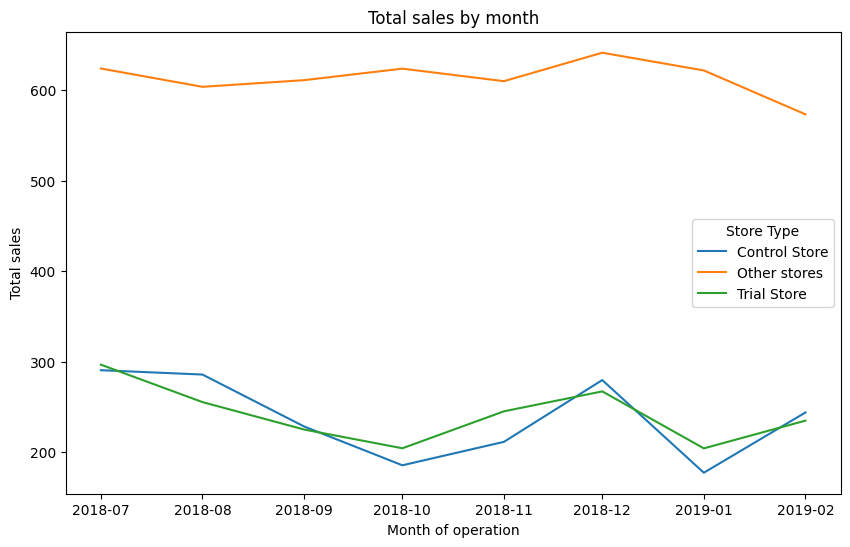

In [18]:
# Create a measureOverTime for visualization
measureOverTimeSales = measureOverTime.copy()
trial_store=77
control_store = 233
# Define store types
measureOverTimeSales['Store_type'] = measureOverTimeSales['STORE_NBR'].apply(
    lambda x: 'Trial Store' if x == trial_store else ('Control Store' if x == control_store else 'Other stores')
)

# Calculate average total sales by year-month and store type
pastSales = measureOverTimeSales.groupby(['YEARMONTH', 'Store_type'])['totSales'].mean().reset_index()

# Convert YEARMONTH to datetime format
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str).str.replace('-', ''), format='%Y%m')

# Filter for months before March 2019
pastSales = pastSales[pastSales['YEARMONTH'] < pd.Period('2019-03', freq='M')]

# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(x='TransactionMonth', y='totSales', hue='Store_type', data=pastSales)
plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.title('Total sales by month')
plt.legend(title='Store Type')
plt.show()


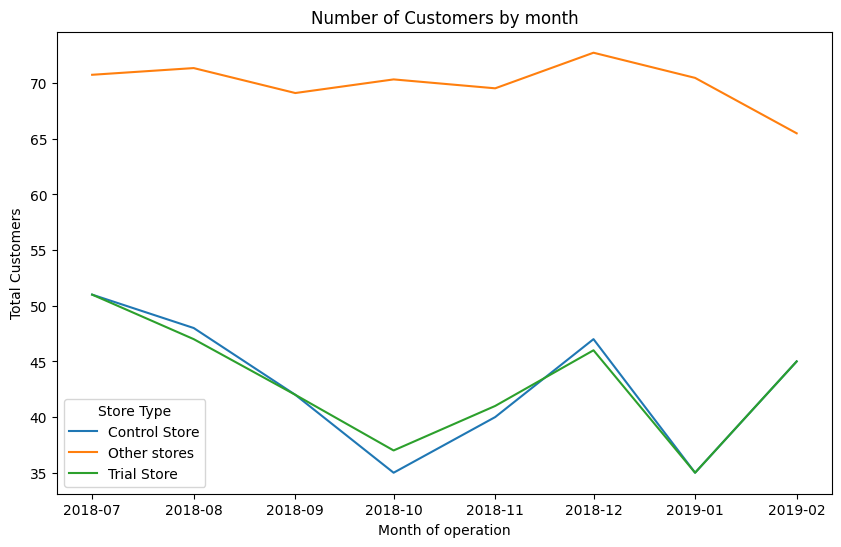

In [19]:
# Calculate average total sales by year-month and store type
pastSales = measureOverTimeSales.groupby(['YEARMONTH', 'Store_type'])['nCustomers'].mean().reset_index()

# Convert YEARMONTH to datetime format
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str).str.replace('-', ''), format='%Y%m')

# Filter for months before March 2019
pastSales = pastSales[pastSales['YEARMONTH'] < pd.Period('2019-03', freq='M')]

# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(x='TransactionMonth', y='nCustomers', hue='Store_type', data=pastSales)
plt.xlabel('Month of operation')
plt.ylabel('Total Customers')
plt.title('Number of Customers by month')
plt.legend(title='Store Type')
plt.show()

In [20]:
# Calculate scaling factor for control sales
scalingFactorForControlSales = (
    pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store) & (pre_trial_measures['YEARMONTH'] < '2019-02')]['totSales'].sum()
    / pre_trial_measures[(pre_trial_measures['STORE_NBR'] == control_store) & (pre_trial_measures['YEARMONTH'] < '2019-02')]['totSales'].sum()
)

# Apply the scaling factor
measureOverTimeSales = measureOverTime.copy()
measureOverTimeSales.loc[measureOverTimeSales['STORE_NBR'] == control_store, 'controlSales'] = (
    measureOverTimeSales.loc[measureOverTimeSales['STORE_NBR'] == control_store, 'totSales'] * scalingFactorForControlSales
)

In [ ]:
measureOverTimeSales[measureOverTimeSales['STORE_NBR'] == 233]

,STORE_NBR,YEARMONTH,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,controlSales
2699,233,2018-07,290.7,51,1.00000,1.629630,5.383333,297.565550
2700,233,2018-08,285.9,48,1.00000,1.600000,5.718000,292.652187
2701,233,2018-09,228.6,42,1.00000,1.555556,5.080000,233.998916
2702,233,2018-10,185.7,35,1.00000,1.555556,5.158333,190.085733
2703,233,2018-11,211.6,40,1.00000,1.512195,5.160976,216.597421
2704,233,2018-12,279.8,47,1.00000,1.500000,5.596000,286.408121
2705,233,2019-01,177.5,35,1.00000,1.342857,5.071429,181.692071
2706,233,2019-02,244.0,45,1.00000,1.489362,5.191489,249.762622
2707,233,2019-03,199.1,40,1.00000,1.439024,4.856098,203.802205
2708,233,2019-04,158.6,30,1.03125,1.393939,4.806061,162.345704


In [21]:
  # Calculate the percentage difference between scaled control sales and trial sales
percentageDiff = pd.merge(
    measureOverTimeSales[measureOverTimeSales['STORE_NBR'] == trial_store][['YEARMONTH', 'totSales']],
    measureOverTimeSales[measureOverTimeSales['STORE_NBR'] == control_store][['YEARMONTH', 'controlSales']],
    on='YEARMONTH'
)

percentageDiff['percentageDiff'] = (
    (percentageDiff['totSales'] - percentageDiff['controlSales']) / percentageDiff['controlSales'] * 100
)

In [22]:
# Calculate standard deviation based on pre-trial percentage difference
stdDev = percentageDiff[percentageDiff['YEARMONTH'] < '2019-02']['percentageDiff'].std()

# Degrees of freedom for 8 months in pre-trial period
degreesOfFreedom = 7

# Calculate t-values for trial months using the test statistic (x - u)/stdDev
percentageDiff['tValue'] = percentageDiff.apply(
    lambda row: (row['percentageDiff'] - 0) / stdDev if row['YEARMONTH'] >= pd.Period('2019-02') else np.nan,
    axis=1
)

# Convert YEARMONTH to TransactionMonth
percentageDiff['TransactionMonth'] = pd.to_datetime(percentageDiff['YEARMONTH'].astype(str), format='%Y-%m')

# Calculate the 95th percentile t-value for the degrees of freedom
t_critical = stats.t.ppf(0.975, degreesOfFreedom)

print(f"95th percentile t-value: {t_critical}")

95th percentile t-value: 2.3646242515927844


In [23]:
percentageDiff

,YEARMONTH,totSales,controlSales,percentageDiff,tValue,TransactionMonth
0,2018-07,296.8,297.565550,-0.257271,NaN,2018-07-01
1,2018-08,255.5,292.652187,-12.694997,NaN,2018-08-01
2,2018-09,225.2,233.998916,-3.760238,NaN,2018-09-01
3,2018-10,204.5,190.085733,7.583035,NaN,2018-10-01
4,2018-11,245.3,216.597421,13.251579,NaN,2018-11-01
5,2018-12,267.3,286.408121,-6.671641,NaN,2018-12-01
6,2019-01,204.4,181.692071,12.498029,NaN,2019-01-01
7,2019-02,235.0,249.762622,-5.910661,-0.593520,2019-02-01
8,2019-03,278.5,203.802205,36.652103,3.680430,2019-03-01
9,2019-04,263.5,162.345704,62.307960,6.256669,2019-04-01


We can observe that the t-value is much larger than the 95th percentile value of
the t-distribution for March and April - i.e. the increase in sales in the trial
store in March and April is statistically greater than in the control store.

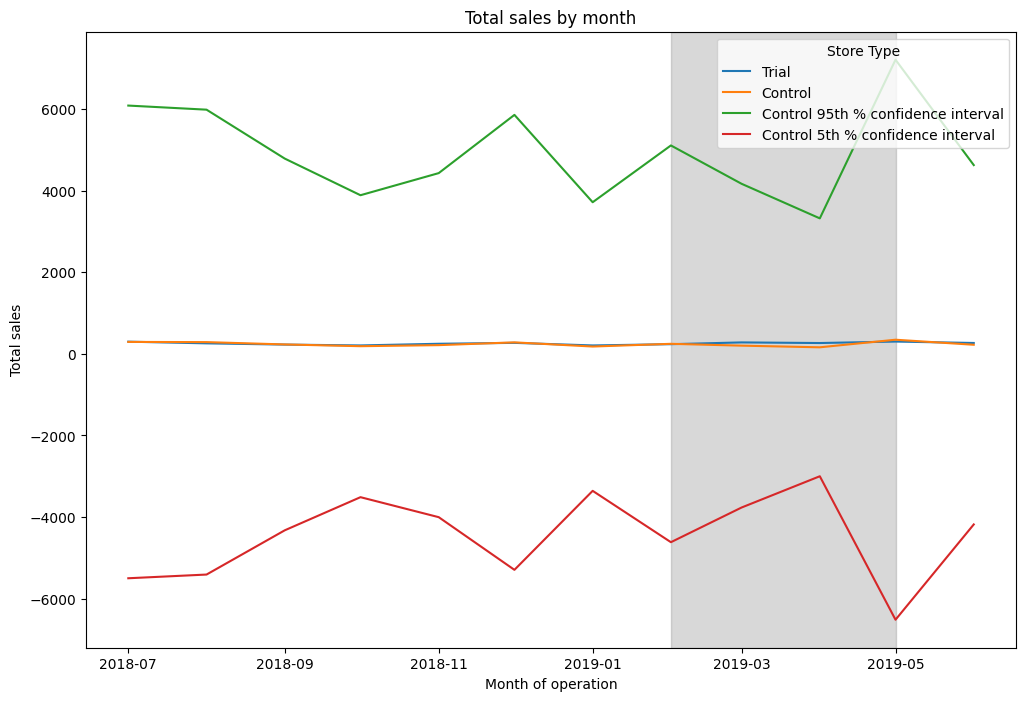

In [24]:
# Create a copy of measureOverTime for visualization
measureOverTimeSales = measureOverTime.copy()

# Define store types
measureOverTimeSales['Store_type'] = measureOverTimeSales['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other stores')
)

# Convert YEARMONTH to TransactionMonth
measureOverTimeSales['TransactionMonth'] = pd.to_datetime(measureOverTimeSales['YEARMONTH'].astype(str), format='%Y-%m')

# Filter only for trial and control stores
pastSales = measureOverTimeSales[measureOverTimeSales['Store_type'].isin(['Trial', 'Control'])]

# Control store 95th percentile
pastSales_Controls95 = pastSales[pastSales['Store_type'] == 'Control'].copy()
pastSales_Controls95['totSales'] *= (1 + stdDev * 2)
pastSales_Controls95['Store_type'] = 'Control 95th % confidence interval'

# Control store 5th percentile
pastSales_Controls5 = pastSales[pastSales['Store_type'] == 'Control'].copy()
pastSales_Controls5['totSales'] *= (1 - stdDev * 2)
pastSales_Controls5['Store_type'] = 'Control 5th % confidence interval'

# Combine data for plotting
trialAssessment = pd.concat([pastSales, pastSales_Controls95, pastSales_Controls5])

# Plotting
plt.figure(figsize=(12, 8))
sns.lineplot(x='TransactionMonth', y='totSales', hue='Store_type', data=trialAssessment)

# Highlight the trial period
plt.axvspan(pd.to_datetime('2019-02', format='%Y-%m'), pd.to_datetime('2019-05', format='%Y-%m'), color='gray', alpha=0.3)

plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.title('Total sales by month')
plt.legend(title='Store Type')
plt.show()


The results show that the trial in store 77 is significantly different to its
control store in the trial period as the trial store performance lies outside the
5% to 95% confidence interval of the control store in two of the three trial
months.

In [25]:
# Calculate scaling factor for control store customers
scalingFactorForControlCust = (
    pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store) & (pre_trial_measures['YEARMONTH'] < '2019-02')]['nCustomers'].sum()
    / pre_trial_measures[(pre_trial_measures['STORE_NBR'] == control_store) & (pre_trial_measures['YEARMONTH'] < '2019-02')]['nCustomers'].sum()
)

# Apply the scaling factor
measureOverTimeCusts = measureOverTime.copy()
measureOverTimeCusts.loc[measureOverTimeCusts['STORE_NBR'] == control_store, 'controlCustomers'] = (
    measureOverTimeCusts.loc[measureOverTimeCusts['STORE_NBR'] == control_store, 'nCustomers'] * scalingFactorForControlCust
)

# Define store types
measureOverTimeCusts['Store_type'] = measureOverTimeCusts['STORE_NBR'].apply(
    lambda x: 'Trial Store' if x == trial_store else ('Control Store' if x == control_store else 'Other stores')
)

# Calculate the percentage difference between scaled control store customers and trial customers
percentageDiff = pd.merge(
    measureOverTimeCusts[measureOverTimeCusts['STORE_NBR'] == trial_store][['YEARMONTH', 'nCustomers']],
    measureOverTimeCusts[measureOverTimeCusts['STORE_NBR'] == control_store][['YEARMONTH', 'controlCustomers']],
    on='YEARMONTH'
)

percentageDiff['percentageDiff'] = (
    (percentageDiff['nCustomers'] - percentageDiff['controlCustomers']) / percentageDiff['controlCustomers'] * 100
)


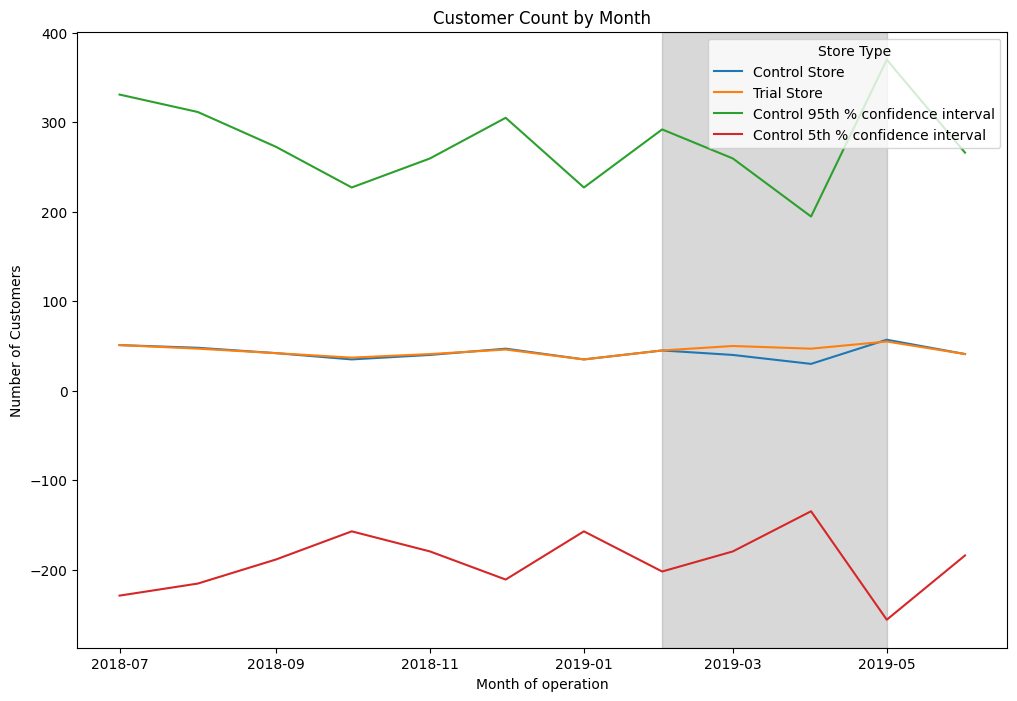

In [26]:
# Calculate standard deviation based on pre-trial percentage difference
stdDev = percentageDiff[percentageDiff['YEARMONTH'] < '2019-02']['percentageDiff'].std()
degreesOfFreedom = 7

# Calculate mean number of customers by year-month and store type
pastCustomers = measureOverTimeCusts.groupby(['YEARMONTH', 'Store_type'])['nCustomers'].mean().reset_index()
pastCustomers.rename(columns={'nCustomers': 'nCusts'}, inplace=True)
pastCustomers = pastCustomers[pastCustomers['Store_type'].isin(['Trial Store', 'Control Store'])]

# Control store 95th percentile
pastCustomers_Controls95 = pastCustomers[pastCustomers['Store_type'] == 'Control Store'].copy()
pastCustomers_Controls95['nCusts'] *= (1 + stdDev * 2)
pastCustomers_Controls95['Store_type'] = 'Control 95th % confidence interval'

# Control store 5th percentile
pastCustomers_Controls5 = pastCustomers[pastCustomers['Store_type'] == 'Control Store'].copy()
pastCustomers_Controls5['nCusts'] *= (1 - stdDev * 2)
pastCustomers_Controls5['Store_type'] = 'Control 5th % confidence interval'

# Combine data for plotting
trialAssessment = pd.concat([pastCustomers, pastCustomers_Controls95, pastCustomers_Controls5])

# Convert 'YEARMONTH' to datetime objects before plotting
trialAssessment['YEARMONTH'] = trialAssessment['YEARMONTH'].dt.to_timestamp()

# Plotting
plt.figure(figsize=(12, 8))
sns.lineplot(x='YEARMONTH', y='nCusts', hue='Store_type', data=trialAssessment)

# Highlight the trial period
plt.axvspan(pd.to_datetime('2019-02', format='%Y-%m'), pd.to_datetime('2019-05', format='%Y-%m'), color='gray', alpha=0.3)

plt.xlabel('Month of operation')
plt.ylabel('Number of Customers')
plt.title('Customer Count by Month')
plt.legend(title='Store Type')
plt.show()


Total number of customers in the trial period for the trial store 77 is significantly higher than the control store for two out of three months, which indicates a positive trial effect.

**TRIAL STORE - 86**

In [27]:
corr_nSales_86 = calculate_correlation(pre_trial_measures, "totSales", 86)
corr_customers_86 = calculate_correlation(pre_trial_measures, "nCustomers", 86)
magnitude_nSales_86 = calculate_magnitude_distance(pre_trial_measures, "totSales", 86)
magnitude_nCustomers_86= calculate_magnitude_distance(pre_trial_measures, "nCustomers", 86)


In [28]:
# Define weight
corr_weight = 0.5

# Calculate combined scores for sales
score_nSales_86 = pd.merge(corr_nSales_86, magnitude_nSales_86, on=['Store1', 'Store2'])
score_nSales_86['scoreNSales'] = corr_weight * score_nSales_86['corr_measure'] + (1 - corr_weight) * score_nSales_86['mag_measure']

# Calculate combined scores for customers
score_nCustomers_86 = pd.merge(corr_customers_86, magnitude_nCustomers_86, on=['Store1', 'Store2'])
score_nCustomers_86['scoreNCust'] = corr_weight * score_nCustomers_86['corr_measure'] + (1 - corr_weight) * score_nCustomers_86['mag_measure']

In [29]:
# Combine sales and customer scores
score_Control_86 = pd.merge(score_nSales_86[['Store1', 'Store2', 'scoreNSales']],
                           score_nCustomers_86[['Store1', 'Store2', 'scoreNCust']],
                           on=['Store1', 'Store2'])

# Calculate final control score
score_Control_86['finalControlScore'] = score_Control_86['scoreNSales'] * 0.5 + score_Control_86['scoreNCust'] * 0.5
score_Control_86.sort_values(by = 'finalControlScore',ascending=False)

,Store1,Store2,scoreNSales,scoreNCust,finalControlScore
80,86,86,1.000000,1.000000,1.000000
147,86,155,0.920423,0.963956,0.942190
102,86,109,0.875142,0.868359,0.871751
107,86,114,0.826848,0.895424,0.861136
130,86,138,0.841792,0.838866,0.840329
...,...,...,...,...,...
101,86,108,-0.249380,-0.176424,-0.212902
48,86,52,-0.283667,-0.276647,-0.280157
112,86,120,-0.350003,-0.219713,-0.284858
39,86,42,-0.362960,-0.312340,-0.337650


We've now found store 155 to be a suitable control store for trial store 86.

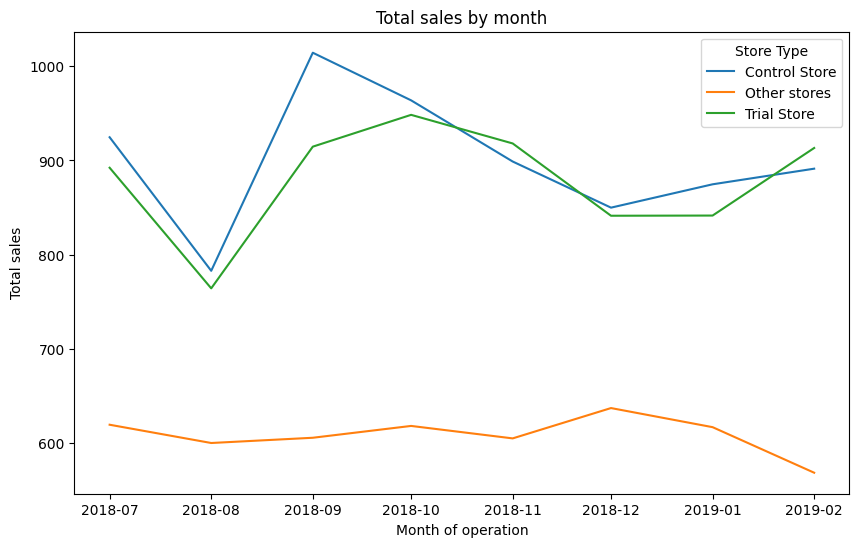

In [30]:
# Create a measureOverTime for visualization
measureOverTimeSales = measureOverTime.copy()
trial_store=86
control_store = 155
# Define store types
measureOverTimeSales['Store_type'] = measureOverTimeSales['STORE_NBR'].apply(
    lambda x: 'Trial Store' if x == trial_store else ('Control Store' if x == control_store else 'Other stores')
)

# Calculate average total sales by year-month and store type
pastSales = measureOverTimeSales.groupby(['YEARMONTH', 'Store_type'])['totSales'].mean().reset_index()

# Convert YEARMONTH to datetime format
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str).str.replace('-', ''), format='%Y%m')

# Filter for months before March 2019
pastSales = pastSales[pastSales['YEARMONTH'] < pd.Period('2019-03', freq='M')]

# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(x='TransactionMonth', y='totSales', hue='Store_type', data=pastSales)
plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.title('Total sales by month')
plt.legend(title='Store Type')
plt.show()


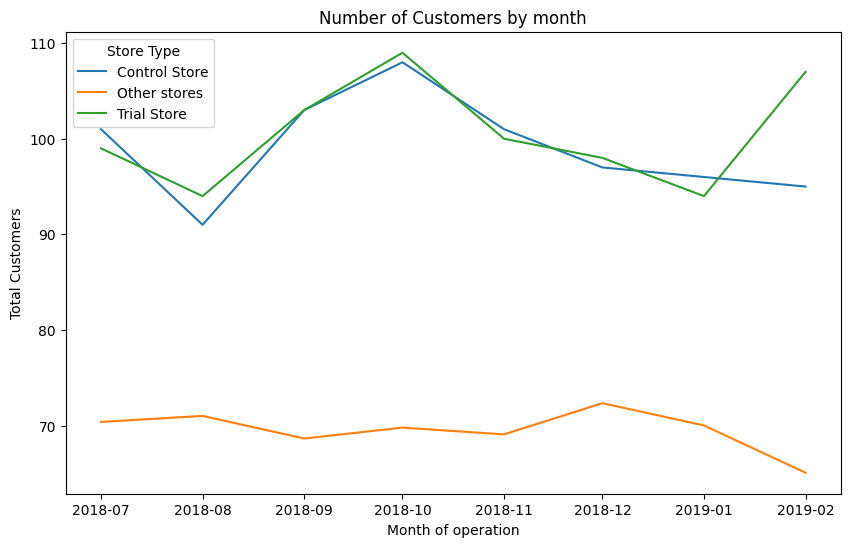

In [31]:
# Calculate average total sales by year-month and store type
pastSales = measureOverTimeSales.groupby(['YEARMONTH', 'Store_type'])['nCustomers'].mean().reset_index()

# Convert YEARMONTH to datetime format
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str).str.replace('-', ''), format='%Y%m')

# Filter for months before March 2019
pastSales = pastSales[pastSales['YEARMONTH'] < pd.Period('2019-03', freq='M')]

# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(x='TransactionMonth', y='nCustomers', hue='Store_type', data=pastSales)
plt.xlabel('Month of operation')
plt.ylabel('Total Customers')
plt.title('Number of Customers by month')
plt.legend(title='Store Type')
plt.show()

In [32]:
# Calculate scaling factor for control sales
scalingFactorForControlSales = (
    pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store) & (pre_trial_measures['YEARMONTH'] < '2019-02')]['totSales'].sum()
    / pre_trial_measures[(pre_trial_measures['STORE_NBR'] == control_store) & (pre_trial_measures['YEARMONTH'] < '2019-02')]['totSales'].sum()
)

# Apply the scaling factor
measureOverTimeSales = measureOverTime.copy()
measureOverTimeSales.loc[measureOverTimeSales['STORE_NBR'] == control_store, 'controlSales'] = (
    measureOverTimeSales.loc[measureOverTimeSales['STORE_NBR'] == control_store, 'totSales'] * scalingFactorForControlSales
)

In [33]:
  # Calculate the percentage difference between scaled control sales and trial sales
percentageDiff = pd.merge(
    measureOverTimeSales[measureOverTimeSales['STORE_NBR'] == trial_store][['YEARMONTH', 'totSales']],
    measureOverTimeSales[measureOverTimeSales['STORE_NBR'] == control_store][['YEARMONTH', 'controlSales']],
    on='YEARMONTH'
)

percentageDiff['percentageDiff'] = (
    (percentageDiff['totSales'] - percentageDiff['controlSales']) / percentageDiff['controlSales'] * 100
)

In [34]:
# Calculate standard deviation based on pre-trial percentage difference
stdDev = percentageDiff[percentageDiff['YEARMONTH'] < '2019-02']['percentageDiff'].std()

# Degrees of freedom for 8 months in pre-trial period
degreesOfFreedom = 7

# Calculate t-values for trial months using the test statistic (x - u)/stdDev
percentageDiff['tValue'] = percentageDiff.apply(
    lambda row: (row['percentageDiff'] - 0) / stdDev if row['YEARMONTH'] >= pd.Period('2019-02') else np.nan,
    axis=1
)

# Convert YEARMONTH to TransactionMonth
percentageDiff['TransactionMonth'] = pd.to_datetime(percentageDiff['YEARMONTH'].astype(str), format='%Y-%m')

# Calculate the 95th percentile t-value for the degrees of freedom
t_critical = stats.t.ppf(0.975, degreesOfFreedom)

print(f"95th percentile t-value: {t_critical}")

95th percentile t-value: 2.3646242515927844


In [35]:
percentageDiff

,YEARMONTH,totSales,controlSales,percentageDiff,tValue,TransactionMonth
0,2018-07,892.20,896.922236,-0.526493,NaN,2018-07-01
1,2018-08,764.05,759.269991,0.629553,NaN,2018-08-01
2,2018-09,914.60,984.034086,-7.056065,NaN,2018-09-01
3,2018-10,948.40,934.948790,1.438711,NaN,2018-10-01
4,2018-11,918.00,871.894555,5.287961,NaN,2018-11-01
5,2018-12,841.20,824.361363,2.042628,NaN,2018-12-01
6,2019-01,841.40,848.418979,-0.827301,NaN,2019-01-01
7,2019-02,913.20,864.522060,5.630619,1.494114,2019-02-01
8,2019-03,1026.80,780.320405,31.586973,8.381769,2019-03-01
9,2019-04,848.20,819.317024,3.525250,0.935444,2019-04-01


We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March - i.e. the increase in sales in the trial store in March is statistically greater than in the control store.

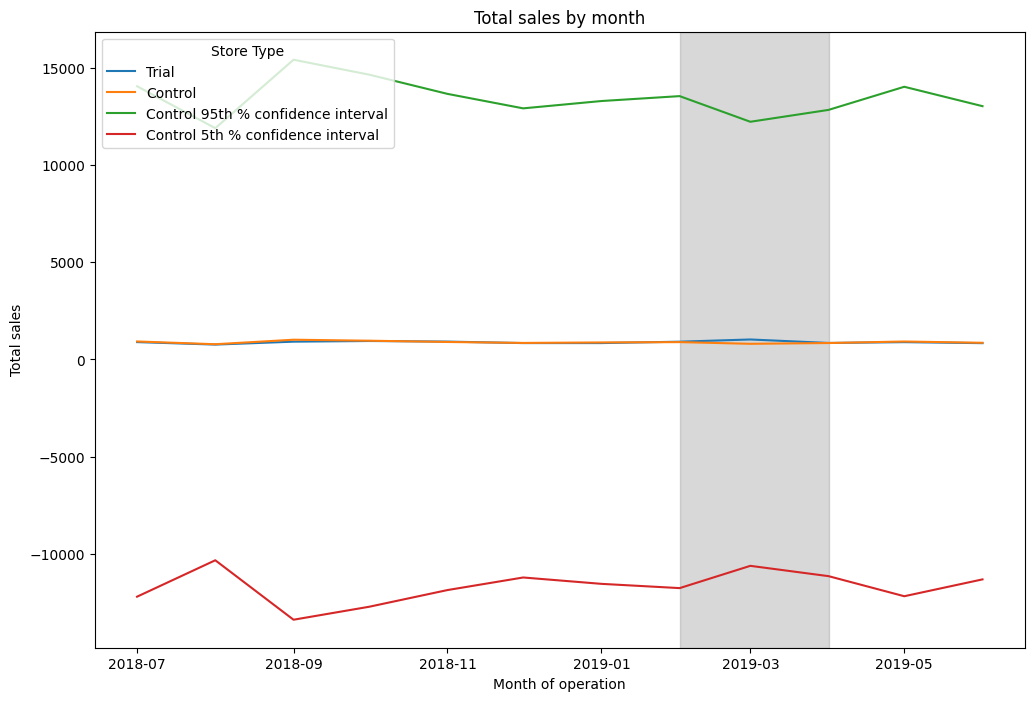

In [36]:
# Create a copy of measureOverTime for visualization
measureOverTimeSales = measureOverTime.copy()

# Define store types
measureOverTimeSales['Store_type'] = measureOverTimeSales['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other stores')
)

# Convert YEARMONTH to TransactionMonth
measureOverTimeSales['TransactionMonth'] = pd.to_datetime(measureOverTimeSales['YEARMONTH'].astype(str), format='%Y-%m')

# Filter only for trial and control stores
pastSales = measureOverTimeSales[measureOverTimeSales['Store_type'].isin(['Trial', 'Control'])]

# Control store 95th percentile
pastSales_Controls95 = pastSales[pastSales['Store_type'] == 'Control'].copy()
pastSales_Controls95['totSales'] *= (1 + stdDev ** 2)
pastSales_Controls95['Store_type'] = 'Control 95th % confidence interval'

# Control store 5th percentile
pastSales_Controls5 = pastSales[pastSales['Store_type'] == 'Control'].copy()
pastSales_Controls5['totSales'] *= (1 - stdDev ** 2)
pastSales_Controls5['Store_type'] = 'Control 5th % confidence interval'

# Combine data for plotting
trialAssessment = pd.concat([pastSales, pastSales_Controls95, pastSales_Controls5])

# Plotting
plt.figure(figsize=(12, 8))
sns.lineplot(x='TransactionMonth', y='totSales', hue='Store_type', data=trialAssessment)

# Highlight the trial period
plt.axvspan(pd.to_datetime('2019-02', format='%Y-%m'), pd.to_datetime('2019-04', format='%Y-%m'), color='gray', alpha=0.3)

plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.title('Total sales by month')
plt.legend(title='Store Type')
plt.show()


The results show that the trial in store 86 is not significantly different to its
control store in the trial period as the trial store performance lies inside the 5%
to 95% confidence interval of the control store in two of the three trial months.

In [37]:
# Calculate scaling factor for control store customers
scalingFactorForControlCust = (
    pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store) & (pre_trial_measures['YEARMONTH'] < '2019-02')]['nCustomers'].sum()
    / pre_trial_measures[(pre_trial_measures['STORE_NBR'] == control_store) & (pre_trial_measures['YEARMONTH'] < '2019-02')]['nCustomers'].sum()
)

# Apply the scaling factor
measureOverTimeCusts = measureOverTime.copy()
measureOverTimeCusts.loc[measureOverTimeCusts['STORE_NBR'] == control_store, 'controlCustomers'] = (
    measureOverTimeCusts.loc[measureOverTimeCusts['STORE_NBR'] == control_store, 'nCustomers'] * scalingFactorForControlCust
)

# Define store types
measureOverTimeCusts['Store_type'] = measureOverTimeCusts['STORE_NBR'].apply(
    lambda x: 'Trial Store' if x == trial_store else ('Control Store' if x == control_store else 'Other stores')
)

# Calculate the percentage difference between scaled control store customers and trial customers
percentageDiff = pd.merge(
    measureOverTimeCusts[measureOverTimeCusts['STORE_NBR'] == trial_store][['YEARMONTH', 'nCustomers']],
    measureOverTimeCusts[measureOverTimeCusts['STORE_NBR'] == control_store][['YEARMONTH', 'controlCustomers']],
    on='YEARMONTH'
)

percentageDiff['percentageDiff'] = (
    (percentageDiff['nCustomers'] - percentageDiff['controlCustomers']) / percentageDiff['controlCustomers'] * 100
)

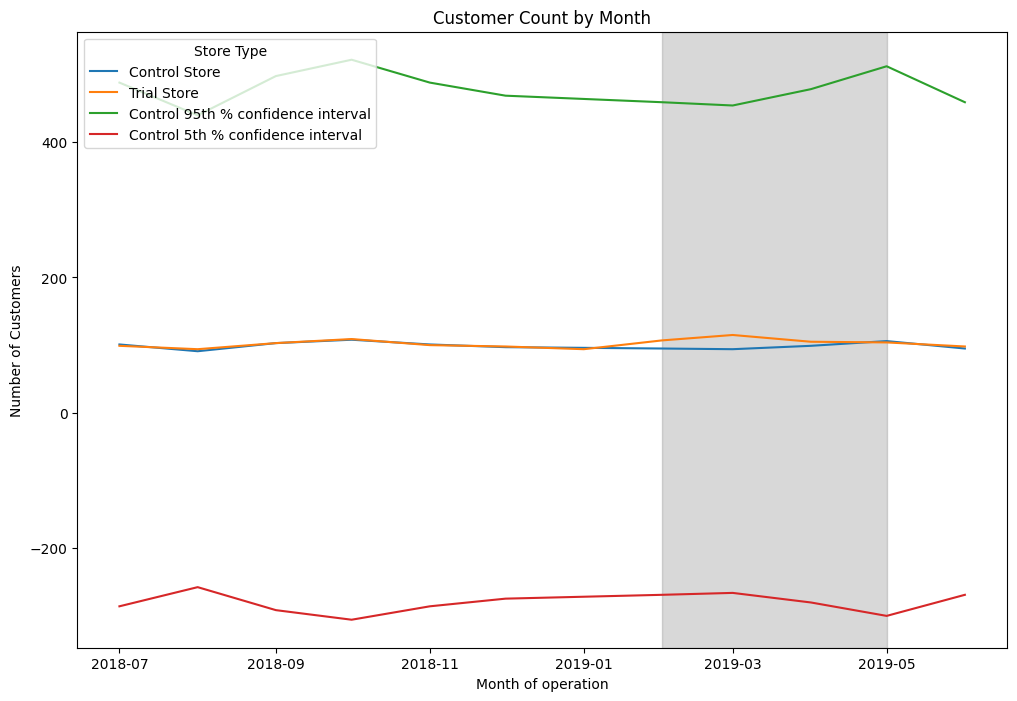

In [38]:
# Calculate standard deviation based on pre-trial percentage difference
stdDev = percentageDiff[percentageDiff['YEARMONTH'] < '2019-02']['percentageDiff'].std()
degreesOfFreedom = 7

# Calculate mean number of customers by year-month and store type
pastCustomers = measureOverTimeCusts.groupby(['YEARMONTH', 'Store_type'])['nCustomers'].mean().reset_index()
pastCustomers.rename(columns={'nCustomers': 'nCusts'}, inplace=True)
pastCustomers = pastCustomers[pastCustomers['Store_type'].isin(['Trial Store', 'Control Store'])]

# Control store 95th percentile
pastCustomers_Controls95 = pastCustomers[pastCustomers['Store_type'] == 'Control Store'].copy()
pastCustomers_Controls95['nCusts'] *= (1 + stdDev * 2)
pastCustomers_Controls95['Store_type'] = 'Control 95th % confidence interval'

# Control store 5th percentile
pastCustomers_Controls5 = pastCustomers[pastCustomers['Store_type'] == 'Control Store'].copy()
pastCustomers_Controls5['nCusts'] *= (1 - stdDev * 2)
pastCustomers_Controls5['Store_type'] = 'Control 5th % confidence interval'

# Combine data for plotting
trialAssessment = pd.concat([pastCustomers, pastCustomers_Controls95, pastCustomers_Controls5])

# Convert 'YEARMONTH' to datetime objects before plotting
trialAssessment['YEARMONTH'] = trialAssessment['YEARMONTH'].dt.to_timestamp()

# Plotting
plt.figure(figsize=(12, 8))
sns.lineplot(x='YEARMONTH', y='nCusts', hue='Store_type', data=trialAssessment)

# Highlight the trial period
plt.axvspan(pd.to_datetime('2019-02', format='%Y-%m'), pd.to_datetime('2019-05', format='%Y-%m'), color='gray', alpha=0.3)

plt.xlabel('Month of operation')
plt.ylabel('Number of Customers')
plt.title('Customer Count by Month')
plt.legend(title='Store Type')
plt.show()

It looks like the number of customers is significantly higher in all of the three
months. This seems to suggest that the trial had a significant impact on increasing
the number of customers in trial store 86 but as we saw, sales were not
significantly higher. We should check with the Category Manager if there were
special deals in the trial store that were may have resulted in lower prices,
impacting the results.

**TRIAL STORE - 88**

In [41]:
corr_nSales_88 = calculate_correlation(pre_trial_measures, "totSales", 88)
corr_customers_88 = calculate_correlation(pre_trial_measures, "nCustomers", 88)
magnitude_nSales_88 = calculate_magnitude_distance(pre_trial_measures, "totSales", 88)
magnitude_nCustomers_88= calculate_magnitude_distance(pre_trial_measures, "nCustomers", 88)


In [42]:
# Define weight
corr_weight = 0.5

# Calculate combined scores for sales
score_nSales_88 = pd.merge(corr_nSales_88, magnitude_nSales_88, on=['Store1', 'Store2'])
score_nSales_88['scoreNSales'] = corr_weight * score_nSales_86['corr_measure'] + (1 - corr_weight) * score_nSales_88['mag_measure']

# Calculate combined scores for customers
score_nCustomers_88 = pd.merge(corr_customers_88, magnitude_nCustomers_88, on=['Store1', 'Store2'])
score_nCustomers_88['scoreNCust'] = corr_weight * score_nCustomers_88['corr_measure'] + (1 - corr_weight) * score_nCustomers_88['mag_measure']

In [43]:
# Combine sales and customer scores
score_Control_88 = pd.merge(score_nSales_88[['Store1', 'Store2', 'scoreNSales']],
                           score_nCustomers_88[['Store1', 'Store2', 'scoreNCust']],
                           on=['Store1', 'Store2'])

# Calculate final control score
score_Control_88['finalControlScore'] = score_Control_88['scoreNSales'] * 0.5 + score_Control_88['scoreNCust'] * 0.5
score_Control_88.sort_values(by = 'finalControlScore',ascending=False)

,Store1,Store2,scoreNSales,scoreNCust,finalControlScore
82,88,88,0.767212,1.000000,0.883606
225,88,237,0.609862,0.967456,0.788659
170,88,178,0.627371,0.880310,0.753840
192,88,201,0.756356,0.715939,0.736148
173,88,181,0.743202,0.645248,0.694225
...,...,...,...,...,...
243,88,256,-0.313501,0.040499,-0.136501
203,88,214,-0.316163,0.033589,-0.141287
138,88,146,-0.381582,0.082077,-0.149752
245,88,258,0.051781,-0.404039,-0.176129


We've now found store 237 to be a suitable control store for trial store 88.

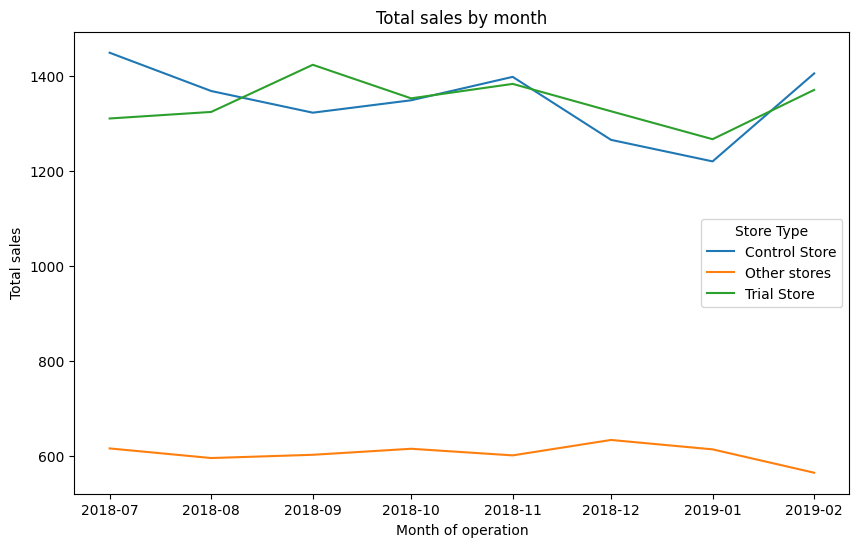

In [45]:
# Create a measureOverTime for visualization
measureOverTimeSales = measureOverTime.copy()
trial_store=88
control_store = 237
# Define store types
measureOverTimeSales['Store_type'] = measureOverTimeSales['STORE_NBR'].apply(
    lambda x: 'Trial Store' if x == trial_store else ('Control Store' if x == control_store else 'Other stores')
)

# Calculate average total sales by year-month and store type
pastSales = measureOverTimeSales.groupby(['YEARMONTH', 'Store_type'])['totSales'].mean().reset_index()

# Convert YEARMONTH to datetime format
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str).str.replace('-', ''), format='%Y%m')

# Filter for months before March 2019
pastSales = pastSales[pastSales['YEARMONTH'] < pd.Period('2019-03', freq='M')]

# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(x='TransactionMonth', y='totSales', hue='Store_type', data=pastSales)
plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.title('Total sales by month')
plt.legend(title='Store Type')
plt.show()


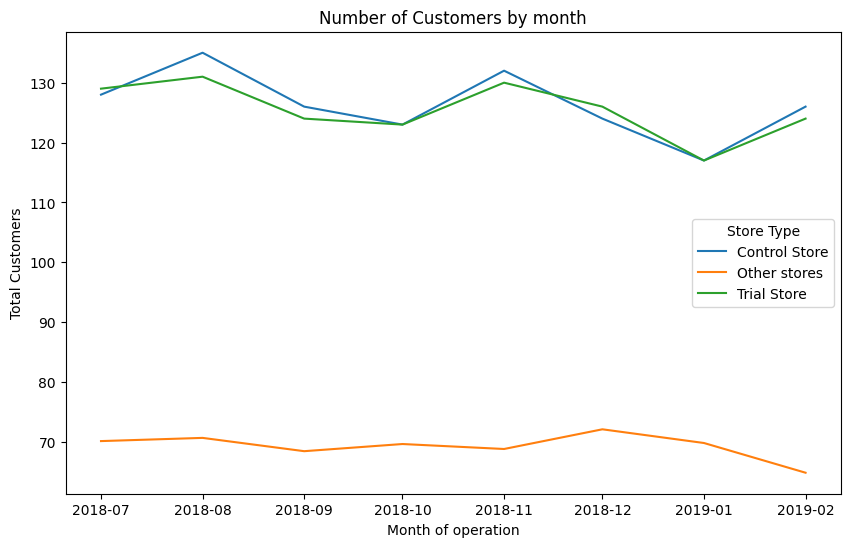

In [46]:
# Calculate average total sales by year-month and store type
pastSales = measureOverTimeSales.groupby(['YEARMONTH', 'Store_type'])['nCustomers'].mean().reset_index()

# Convert YEARMONTH to datetime format
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'].astype(str).str.replace('-', ''), format='%Y%m')

# Filter for months before March 2019
pastSales = pastSales[pastSales['YEARMONTH'] < pd.Period('2019-03', freq='M')]

# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(x='TransactionMonth', y='nCustomers', hue='Store_type', data=pastSales)
plt.xlabel('Month of operation')
plt.ylabel('Total Customers')
plt.title('Number of Customers by month')
plt.legend(title='Store Type')
plt.show()

In [47]:
# Calculate scaling factor for control sales
scalingFactorForControlSales = (
    pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store) & (pre_trial_measures['YEARMONTH'] < '2019-02')]['totSales'].sum()
    / pre_trial_measures[(pre_trial_measures['STORE_NBR'] == control_store) & (pre_trial_measures['YEARMONTH'] < '2019-02')]['totSales'].sum()
)

# Apply the scaling factor
measureOverTimeSales = measureOverTime.copy()
measureOverTimeSales.loc[measureOverTimeSales['STORE_NBR'] == control_store, 'controlSales'] = (
    measureOverTimeSales.loc[measureOverTimeSales['STORE_NBR'] == control_store, 'totSales'] * scalingFactorForControlSales
)

In [48]:
  # Calculate the percentage difference between scaled control sales and trial sales
percentageDiff = pd.merge(
    measureOverTimeSales[measureOverTimeSales['STORE_NBR'] == trial_store][['YEARMONTH', 'totSales']],
    measureOverTimeSales[measureOverTimeSales['STORE_NBR'] == control_store][['YEARMONTH', 'controlSales']],
    on='YEARMONTH'
)

percentageDiff['percentageDiff'] = (
    (percentageDiff['totSales'] - percentageDiff['controlSales']) / percentageDiff['controlSales'] * 100
)

In [49]:
# Calculate standard deviation based on pre-trial percentage difference
stdDev = percentageDiff[percentageDiff['YEARMONTH'] < '2019-02']['percentageDiff'].std()

# Degrees of freedom for 8 months in pre-trial period
degreesOfFreedom = 7

# Calculate t-values for trial months using the test statistic (x - u)/stdDev
percentageDiff['tValue'] = percentageDiff.apply(
    lambda row: (row['percentageDiff'] - 0) / stdDev if row['YEARMONTH'] >= pd.Period('2019-02') else np.nan,
    axis=1
)

# Convert YEARMONTH to TransactionMonth
percentageDiff['TransactionMonth'] = pd.to_datetime(percentageDiff['YEARMONTH'].astype(str), format='%Y-%m')

# Calculate the 95th percentile t-value for the degrees of freedom
t_critical = stats.t.ppf(0.975, degreesOfFreedom)

print(f"95th percentile t-value: {t_critical}")

95th percentile t-value: 2.3646242515927844


In [50]:
percentageDiff

,YEARMONTH,totSales,controlSales,percentageDiff,tValue,TransactionMonth
0,2018-07,1310.00,1450.657086,-9.696095,NaN,2018-07-01
1,2018-08,1323.80,1369.931485,-3.367430,NaN,2018-08-01
2,2018-09,1423.00,1324.260425,7.456205,NaN,2018-09-01
3,2018-10,1352.40,1350.401097,0.148023,NaN,2018-10-01
4,2018-11,1382.80,1399.777923,-1.212901,NaN,2018-11-01
5,2018-12,1325.20,1266.971288,4.595898,NaN,2018-12-01
6,2019-01,1266.40,1221.600696,3.667262,NaN,2019-01-01
7,2019-02,1370.20,1406.989143,-2.614742,-0.456726,2019-02-01
8,2019-03,1477.20,1210.082775,22.074294,3.855795,2019-03-01
9,2019-04,1439.40,1206.477165,19.306029,3.372253,2019-04-01


We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the control store

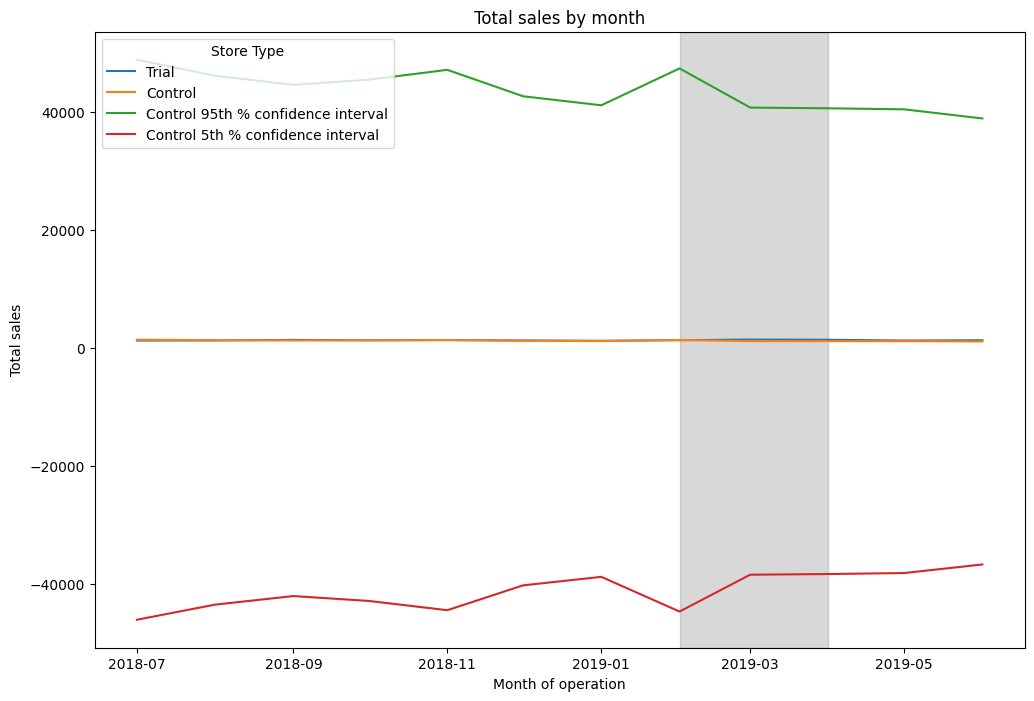

In [51]:
# Create a copy of measureOverTime for visualization
measureOverTimeSales = measureOverTime.copy()

# Define store types
measureOverTimeSales['Store_type'] = measureOverTimeSales['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else ('Control' if x == control_store else 'Other stores')
)

# Convert YEARMONTH to TransactionMonth
measureOverTimeSales['TransactionMonth'] = pd.to_datetime(measureOverTimeSales['YEARMONTH'].astype(str), format='%Y-%m')

# Filter only for trial and control stores
pastSales = measureOverTimeSales[measureOverTimeSales['Store_type'].isin(['Trial', 'Control'])]

# Control store 95th percentile
pastSales_Controls95 = pastSales[pastSales['Store_type'] == 'Control'].copy()
pastSales_Controls95['totSales'] *= (1 + stdDev ** 2)
pastSales_Controls95['Store_type'] = 'Control 95th % confidence interval'

# Control store 5th percentile
pastSales_Controls5 = pastSales[pastSales['Store_type'] == 'Control'].copy()
pastSales_Controls5['totSales'] *= (1 - stdDev ** 2)
pastSales_Controls5['Store_type'] = 'Control 5th % confidence interval'

# Combine data for plotting
trialAssessment = pd.concat([pastSales, pastSales_Controls95, pastSales_Controls5])

# Plotting
plt.figure(figsize=(12, 8))
sns.lineplot(x='TransactionMonth', y='totSales', hue='Store_type', data=trialAssessment)

# Highlight the trial period
plt.axvspan(pd.to_datetime('2019-02', format='%Y-%m'), pd.to_datetime('2019-04', format='%Y-%m'), color='gray', alpha=0.3)

plt.xlabel('Month of operation')
plt.ylabel('Total sales')
plt.title('Total sales by month')
plt.legend(title='Store Type')
plt.show()


The results show that the trial in store 88 is significantly different to its
control store in the trial period as the trial store performance lies outside of
the 5% to 95% confidence interval of the control store in two of the three trial
months.

In [52]:
# Calculate scaling factor for control store customers
scalingFactorForControlCust = (
    pre_trial_measures[(pre_trial_measures['STORE_NBR'] == trial_store) & (pre_trial_measures['YEARMONTH'] < '2019-02')]['nCustomers'].sum()
    / pre_trial_measures[(pre_trial_measures['STORE_NBR'] == control_store) & (pre_trial_measures['YEARMONTH'] < '2019-02')]['nCustomers'].sum()
)

# Apply the scaling factor
measureOverTimeCusts = measureOverTime.copy()
measureOverTimeCusts.loc[measureOverTimeCusts['STORE_NBR'] == control_store, 'controlCustomers'] = (
    measureOverTimeCusts.loc[measureOverTimeCusts['STORE_NBR'] == control_store, 'nCustomers'] * scalingFactorForControlCust
)

# Define store types
measureOverTimeCusts['Store_type'] = measureOverTimeCusts['STORE_NBR'].apply(
    lambda x: 'Trial Store' if x == trial_store else ('Control Store' if x == control_store else 'Other stores')
)

# Calculate the percentage difference between scaled control store customers and trial customers
percentageDiff = pd.merge(
    measureOverTimeCusts[measureOverTimeCusts['STORE_NBR'] == trial_store][['YEARMONTH', 'nCustomers']],
    measureOverTimeCusts[measureOverTimeCusts['STORE_NBR'] == control_store][['YEARMONTH', 'controlCustomers']],
    on='YEARMONTH'
)

percentageDiff['percentageDiff'] = (
    (percentageDiff['nCustomers'] - percentageDiff['controlCustomers']) / percentageDiff['controlCustomers'] * 100
)

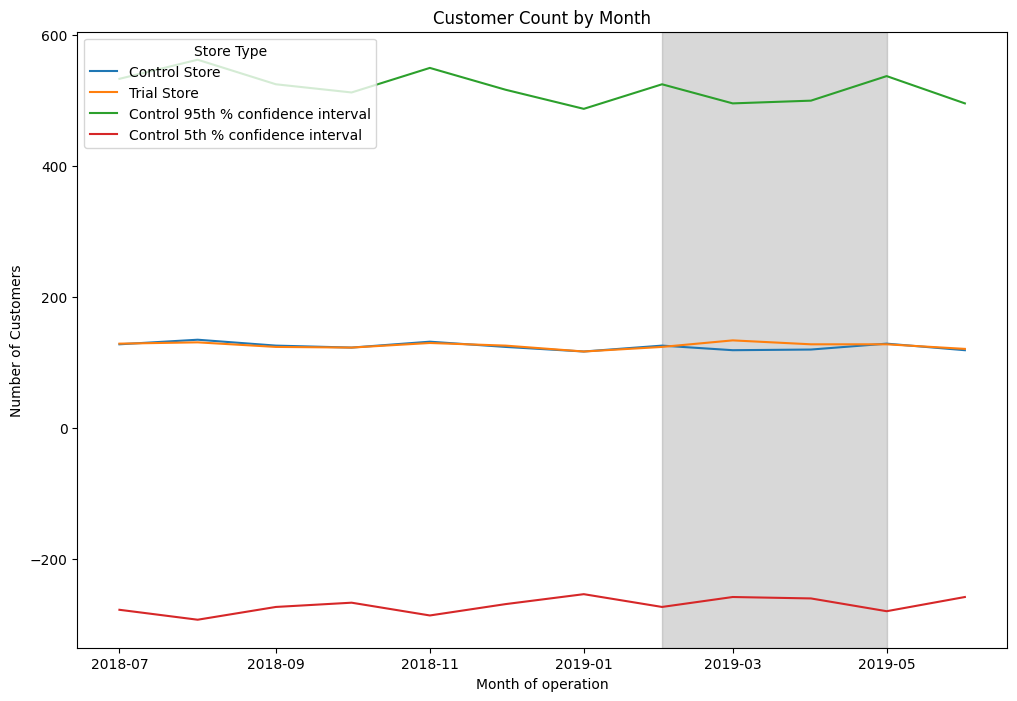

In [53]:
# Calculate standard deviation based on pre-trial percentage difference
stdDev = percentageDiff[percentageDiff['YEARMONTH'] < '2019-02']['percentageDiff'].std()
degreesOfFreedom = 7

# Calculate mean number of customers by year-month and store type
pastCustomers = measureOverTimeCusts.groupby(['YEARMONTH', 'Store_type'])['nCustomers'].mean().reset_index()
pastCustomers.rename(columns={'nCustomers': 'nCusts'}, inplace=True)
pastCustomers = pastCustomers[pastCustomers['Store_type'].isin(['Trial Store', 'Control Store'])]

# Control store 95th percentile
pastCustomers_Controls95 = pastCustomers[pastCustomers['Store_type'] == 'Control Store'].copy()
pastCustomers_Controls95['nCusts'] *= (1 + stdDev * 2)
pastCustomers_Controls95['Store_type'] = 'Control 95th % confidence interval'

# Control store 5th percentile
pastCustomers_Controls5 = pastCustomers[pastCustomers['Store_type'] == 'Control Store'].copy()
pastCustomers_Controls5['nCusts'] *= (1 - stdDev * 2)
pastCustomers_Controls5['Store_type'] = 'Control 5th % confidence interval'

# Combine data for plotting
trialAssessment = pd.concat([pastCustomers, pastCustomers_Controls95, pastCustomers_Controls5])

# Convert 'YEARMONTH' to datetime objects before plotting
trialAssessment['YEARMONTH'] = trialAssessment['YEARMONTH'].dt.to_timestamp()

# Plotting
plt.figure(figsize=(12, 8))
sns.lineplot(x='YEARMONTH', y='nCusts', hue='Store_type', data=trialAssessment)

# Highlight the trial period
plt.axvspan(pd.to_datetime('2019-02', format='%Y-%m'), pd.to_datetime('2019-05', format='%Y-%m'), color='gray', alpha=0.3)

plt.xlabel('Month of operation')
plt.ylabel('Number of Customers')
plt.title('Customer Count by Month')
plt.legend(title='Store Type')
plt.show()

Total number of customers in the trial period for the trial store 88 is significantly higher than the control store for two out of three months, which indicates a
positive trial effect.


